[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aurelio-labs/semantic-chunkers/blob/main/docs/01-video-chunking.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/aurelio-labs/semantic-chunkers/blob/main/docs/01-video-chunking.ipynb)

# Chunking Videos using ViT Encoding

Similar to prose, videos are a sequence of frames with a temporal component.

By using similarity between these frames, we can effectively split videos based on the constitutent frames' semantic


Let's start by loading a test video and splitting it into frames

In [ ]:
!pip install -qU \
    "semantic-chunkers[stats]" \
    "semantic-router[vision]==0.0.39" \
    opencv-python

In [1]:
import cv2

vidcap = cv2.VideoCapture("https://www.w3schools.com/html/mov_bbb.mp4")

frames = []
success, image = vidcap.read()
while success:
    frames.append(image)
    success, image = vidcap.read()
len(frames)

250

In [2]:
from PIL import Image

image_frames = list(map(Image.fromarray, frames))
len(image_frames)

250

Now that we have the frames loaded, we can go ahead and use the `Chunker` functionality to create splits based on frame similarity

First, lets initialise our ViT Encoder

In [4]:
import torch
from semantic_router.encoders import VitEncoder

device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using '{device}'")

encoder = VitEncoder(device=device)

Using 'mps'


/Users/jamesbriggs/opt/anaconda3/envs/semantic-chunkers/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Now lets initialise our Splitter. 

> Note: currently, we can only use `semantic_chunkers.chunkers.ConsecutiveChunker` for image content

In [4]:
from semantic_chunkers import ConsecutiveChunker

chunker = ConsecutiveChunker(encoder=encoder, score_threshold=0.6)

chunks = chunker(docs=[image_frames])
print(f"{len(chunks[0])} chunks identified")

100%|██████████| 249/249 [00:00<00:00, 74737.49it/s]

2 chunks identified


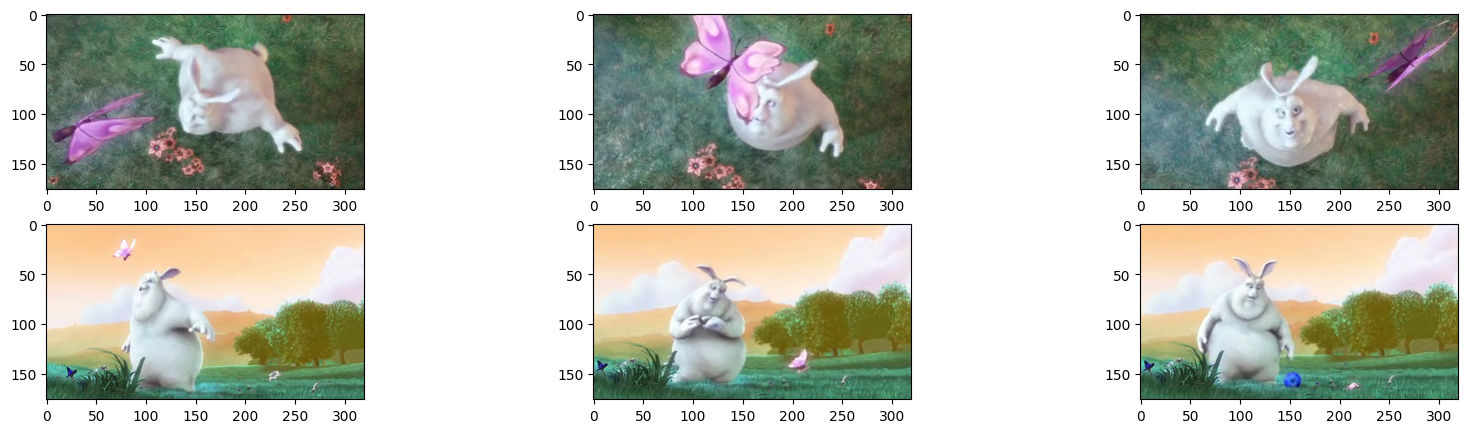

In [5]:
import matplotlib.pyplot as plt

f, axarr = plt.subplots(len(chunks[0]), 3, figsize=(20, 5))

for i, chunk in enumerate(chunks[0]):
    axarr[i, 0].imshow(chunk.splits[0])
    num_docs = len(chunk.splits)
    mid = num_docs // 2
    axarr[i, 1].imshow(chunk.splits[mid])
    axarr[i, 2].imshow(chunk.splits[num_docs - 1])

The video has two main camera angles, which is represented here by two Semantic Chunks. (each row represents 1 chunk, columns represent frame samples within the chunk)

Chunk #1 - scene 1, high angle shot of Big Buck Bunny looking up at a butterfly

Chunk #2 - scene 2, straight-up angle shot of Big Buck Bunny, with a distinct yellow background

Using ViT features from frames, we were able to distinguish these two scenes

## What about non-animated footage?

Depending on the complexity of the footage you're trying to semantically chunk, you might need to adjust the `threshold` parameter for `semantic_chunker`

Let's use a public domain video from the automotive domain to demonstrate

In [6]:
vidcap = cv2.VideoCapture(
    "http://commondatastorage.googleapis.com/gtv-videos-bucket/sample/WeAreGoingOnBullrun.mp4"
)

frames = []
success, image = vidcap.read()
while success:
    frames.append(image)
    success, image = vidcap.read()
image_frames = list(map(Image.fromarray, frames))
len(image_frames)

1139

### How to pick the right `threshold`?

It's an art as much as it is a science.

A lower threshold value means that the chunker is more lenient to accepting frames within a `chunk`, with threshold 0 meaning all frames are just 1 chunk.

Conversely, the higher the threshold value, the stricter the chunker becomes, with threshold 1 putting each frame (besides 100% identical ones) into the same chunk.

For this video, we empirically found a value of `0.65` to work the best.

In [7]:
chunker = ConsecutiveChunker(encoder=encoder, score_threshold=0.65)

chunks = chunker(docs=[image_frames])

100%|██████████| 1138/1138 [00:00<00:00, 246163.90it/s]


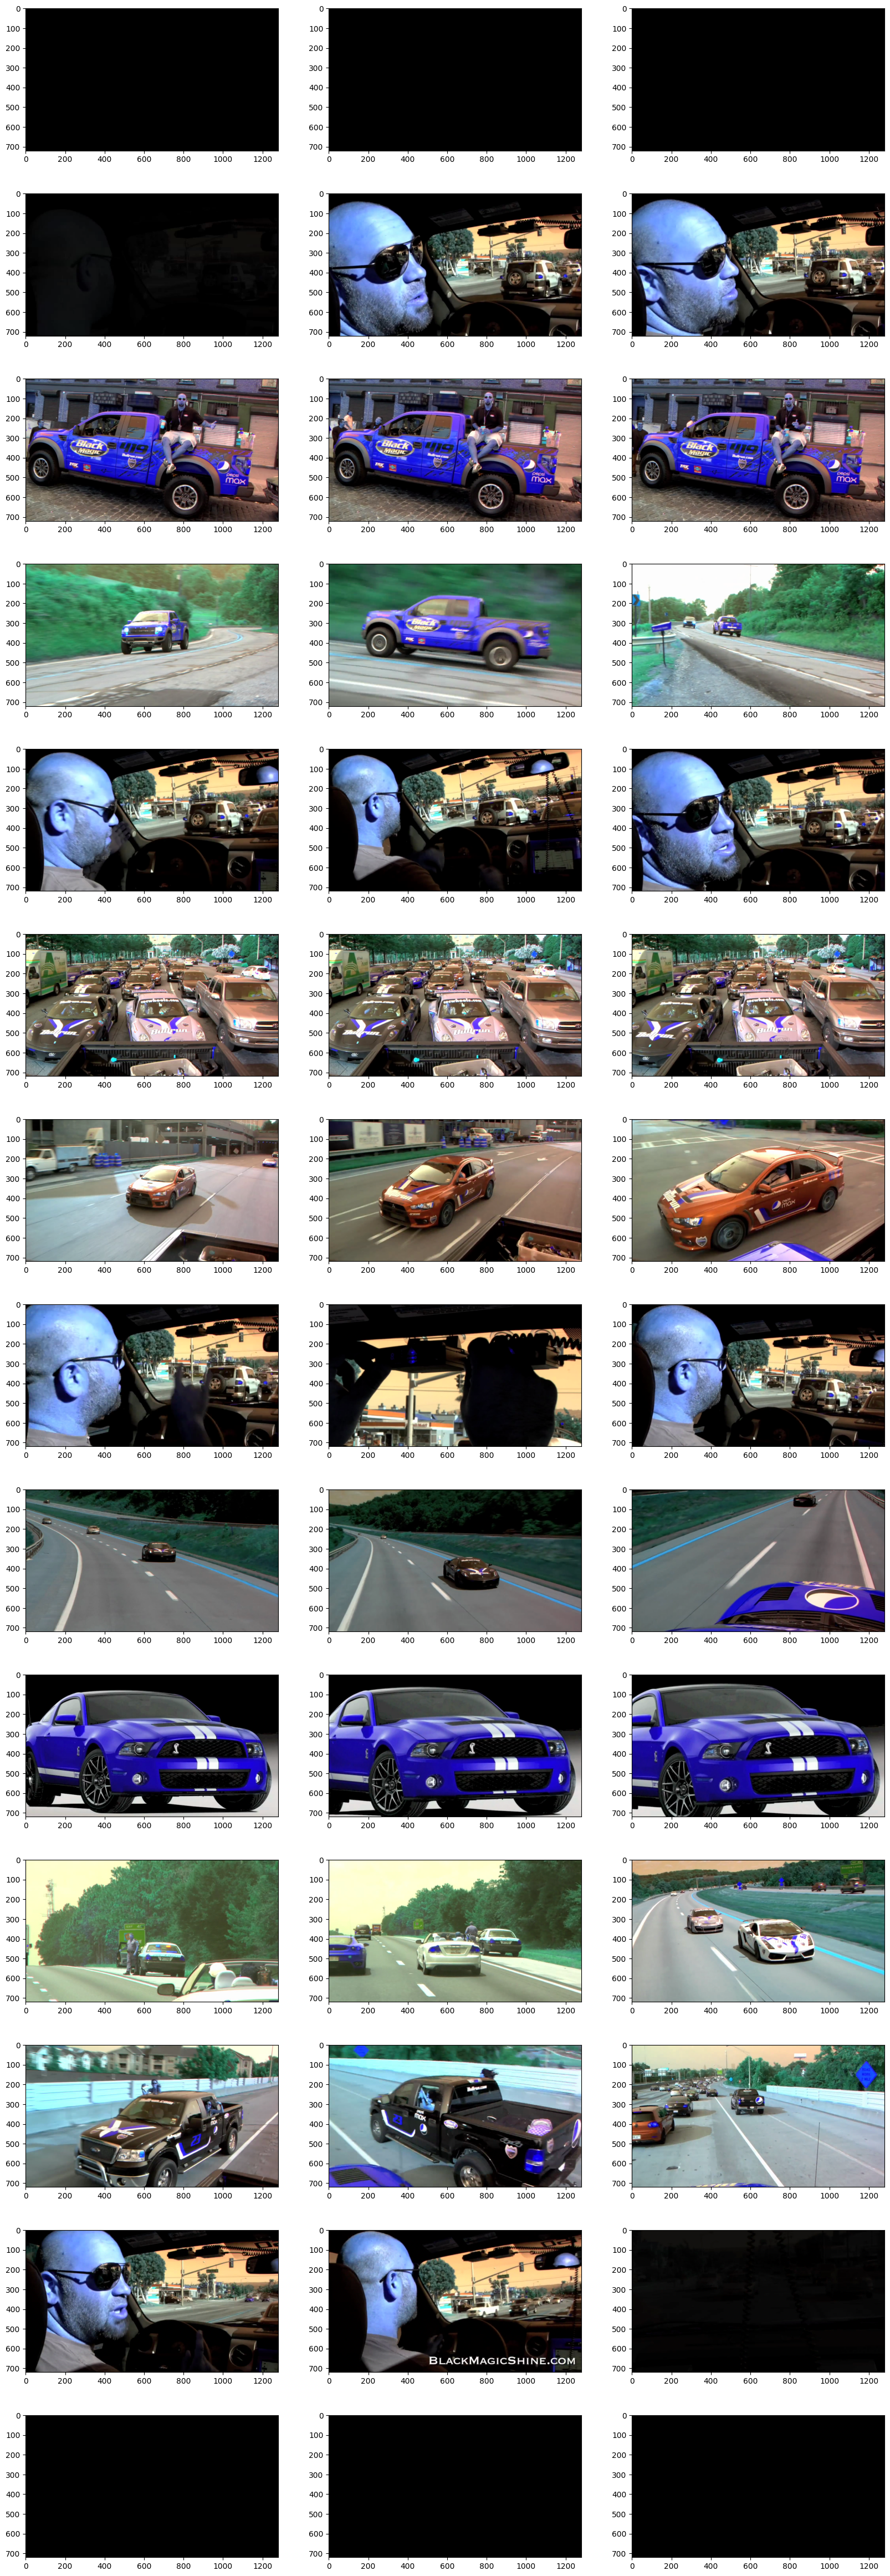

In [9]:
import matplotlib.pyplot as plt

f, axarr = plt.subplots(len(chunks[0]), 3, figsize=(20, 60))

for i, chunk in enumerate(chunks[0]):
    axarr[i, 0].imshow(chunk.splits[0])
    num_docs = len(chunk.splits)
    mid = num_docs // 2
    axarr[i, 1].imshow(chunk.splits[mid])
    axarr[i, 2].imshow(chunk.splits[num_docs - 1])

---